# MRI Demand Modelling by Continuous Age – Emergency vs Elective Pathways

Building on the general MRI demand model, this notebook introduces a pathway-level breakdown by modelling emergency and elective MRI utilisation separately. Demand is estimated per 1,000 population under age 85 using continuous-age models, allowing fine-grained prediction of diagnostic imaging needs across patient types and clinical contexts.

The analysis compares Poisson Generalised Linear Models (GLMs) and Random Forest regressors fitted separately to emergency and elective data, and evaluates ensemble approaches to blend their strengths. Predicted values are smoothed and visualised alongside observed age-specific MRI rates.

This pathway-level modelling enables more precise allocation of diagnostic imaging capacity across urgent and planned care, informing NHS resource planning for Community Diagnostic Centres (CDCs), acute trusts, and regional imaging networks. It provides a foundational layer for demand stratification by care setting, age, and geography.

In [2]:
# ---- Step 0: Import Packages ----

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120


In [3]:
# ---- Step 1: Define File Paths and Load CSVs ----

# Set base directory
base_path = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/"
    "nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"
)

# Define file paths
mri_master_path = os.path.join(base_path, "mri_master.csv")
modality_counts_path = os.path.join(base_path, "modality_procedure_counts_by_age_band_2024.csv")
population_path = os.path.join(base_path, "south_west_population_2024.csv")

# Load datasets
mri_master_df = pd.read_csv(mri_master_path)
modality_counts_df = pd.read_csv(modality_counts_path)
population_df = pd.read_csv(population_path)

# ---- Preview: MRI Master Dataset ----
print("MRI Master Data – Columns:")
print(mri_master_df.columns.tolist())
print("\nPreview:")
print(mri_master_df.head(), "\n")

# ---- Preview: Modality Counts ----
print("Modality Procedure Counts – Columns:")
print(modality_counts_df.columns.tolist())
print("\nPreview:")
print(modality_counts_df.head(), "\n")

# ---- Preview: Population Data ----
print("Population 2024 – Columns:")
print(population_df.columns.tolist())
print("\nPreview:")
print(population_df.head())


MRI Master Data – Columns:
['icb_code', 'icb_name', 'lsoa_code', 'nhs_region', 'site_code', 'site_name', 'provider_code', 'provider_name', 'activity_month', 'financial_year', 'financial_month', 'test_date', 'age', 'sex', 'modality', 'sub_modality', 'procedure_name', 'referral_type', 'patient_source', 'cancer_flag', 'subcancer_flag', 'referring_org_code', 'referring_org_name', 'age_band', 'age_mid', 'modality_clean', 'ps_bucket', 'is_ct', 'is_mri', 'is_endo']

Preview:
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029036   
1      11X  NHS SOMERSET ICB - 11X  E01014470   
2      11X  NHS SOMERSET ICB - 11X  E01032629   
3      11X  NHS SOMERSET ICB - 11X  E01032627   
4      11X  NHS SOMERSET ICB - 11X  E01029271   

                          nhs_region site_code  \
0                                NaN     NTPH1   
1    Head structure (body structure)     RH504   
2    Limb structure (body structure)     RH5A8   
3    Head structure (body struct

Age field type: float64
Missing values in age: 8
Age summary statistics:
count    324885.000000
mean         53.741699
std          20.045638
min           0.000000
25%          39.000000
50%          56.000000
75%          70.000000
max         109.000000
Name: age, dtype: float64


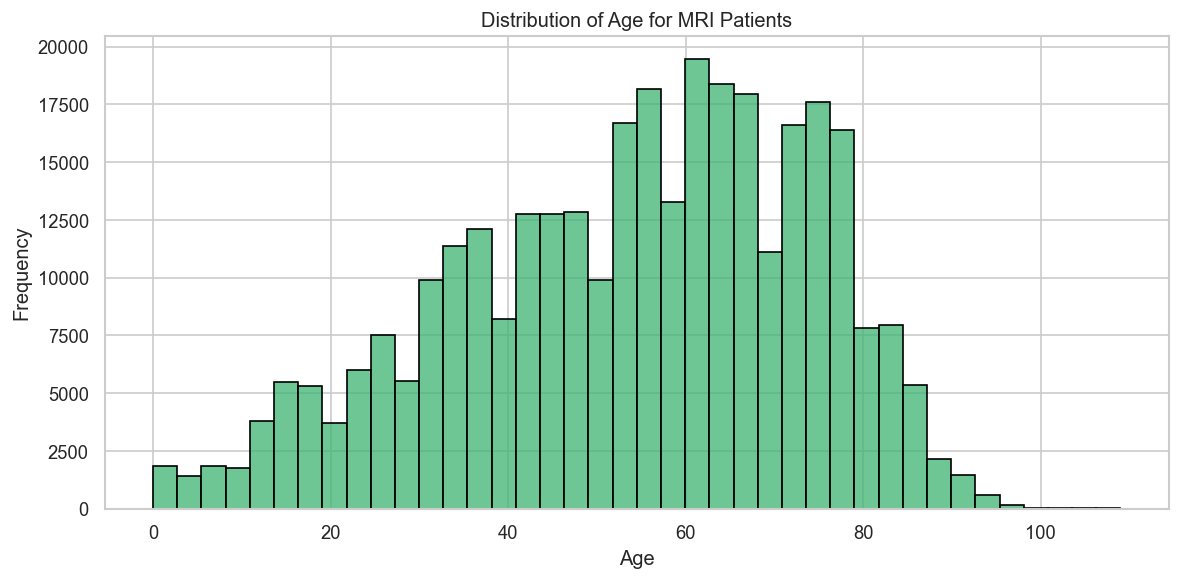

In [4]:
# ---- Step 2: Filter MRI Records and Check Age Field ----

# Keep only MRI procedures
mri_df = mri_master_df[mri_master_df["is_mri"] == 1].copy()

# Check for null or invalid ages
print("Age field type:", mri_df["age"].dtype)
print("Missing values in age:", mri_df["age"].isna().sum())
print("Age summary statistics:")
print(mri_df["age"].describe())

# Plot distribution of age for MRI patients
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(
    mri_df["age"].dropna(),
    bins=40,
    kde=False,
    color="mediumseagreen",
    edgecolor="black"
)
plt.title("Distribution of Age for MRI Patients")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [5]:
# ---- Step 3.1: Classify Patient Source as Emergency / Elective ----

def classify_source(source):
    emergency_sources = [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)"
    ]
    elective_sources = [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)"
    ]
    if source in emergency_sources:
        return "Emergency"
    elif source in elective_sources:
        return "Elective"
    return "Other"

mri_master_df["source_group"] = mri_master_df["patient_source"].map(classify_source)

# ---- Step 3.2: Ensure 'exam_count' column exists ----
if "exam_count" not in mri_master_df.columns:
    mri_master_df["exam_count"] = 1

# ---- Step 3.3: Split MRI Dataset by Source Type ----

df_total = mri_master_df.copy()
df_emergency = mri_master_df[mri_master_df["source_group"] == "Emergency"].copy()
df_elective = mri_master_df[mri_master_df["source_group"] == "Elective"].copy()

# ---- Step 3.4: Define Age Band Ordering ----

age_band_order = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]

# ---- Step 3.5: Summarise Exam Counts by Age Band ----

def summarise_demand(df, label):
    summary = (
        df.groupby("age_band")["exam_count"]
        .sum()
        .reset_index()
        .rename(columns={"exam_count": label})
    )
    return summary

summary_total = summarise_demand(df_total, "MRI_Total")
summary_emergency = summarise_demand(df_emergency, "MRI_Emergency")
summary_elective = summarise_demand(df_elective, "MRI_Elective")

# ---- Step 3.6: Bin Age from Population File and Merge ----

# Define age bins and labels
age_bins = list(range(0, 90, 5)) + [200]  # [0, 5, ..., 85, 200]
age_labels = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]

# Convert continuous age to categorical age_band
population_df["age_band"] = pd.cut(
    population_df["age"],
    bins=age_bins,
    labels=age_labels,
    right=False,
    include_lowest=True
)

# Aggregate population by age_band (retain all category levels)
age_band_population = (
    population_df
    .groupby("age_band", observed=False)["population"]
    .sum()
    .reset_index()
    .rename(columns={"population": "population_2024"})
)

# Merge summaries with population
mri_naive_df = (
    summary_total
    .merge(summary_emergency, on="age_band", how="left")
    .merge(summary_elective, on="age_band", how="left")
    .merge(age_band_population, on="age_band", how="left")
)

# Fill any missing demand values with 0
mri_naive_df[["MRI_Emergency", "MRI_Elective"]] = mri_naive_df[["MRI_Emergency", "MRI_Elective"]].fillna(0)


In [6]:
# ---- Step 3.7: Calculate MRI Rates per 1k and 10k Population ----

# Calculate rates for each demand type
for col in ["MRI_Total", "MRI_Emergency", "MRI_Elective"]:
    mri_naive_df[f"{col.lower()}_per_10k"] = (
        mri_naive_df[col] / mri_naive_df["population_2024"]
    ) * 10000

    mri_naive_df[f"{col.lower()}_per_1k"] = (
        mri_naive_df[col] / mri_naive_df["population_2024"]
    ) * 1000

# Round rate columns for display
rate_cols = [col for col in mri_naive_df.columns if "_per_" in col]
mri_naive_df[rate_cols] = mri_naive_df[rate_cols].round(2)

# ---- Step 3.8: Sort by Age Band and Display ----

# Define ordered list for age bands
age_band_order = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]

# Ensure age_band is a categorical type with correct order
mri_naive_df["age_band"] = pd.Categorical(
    mri_naive_df["age_band"],
    categories=age_band_order,
    ordered=True
)

# Sort by age_band
mri_naive_df = mri_naive_df.sort_values("age_band").reset_index(drop=True)

# Select display columns
display_cols = [
    "age_band", "population_2024",
    "MRI_Total", "mri_total_per_1k",
    "MRI_Emergency", "mri_emergency_per_1k",
    "MRI_Elective", "mri_elective_per_1k"
]

# Print output summary
print(mri_naive_df[display_cols])


   age_band  population_2024  MRI_Total  mri_total_per_1k  MRI_Emergency  \
0       0-4           280713       2232              7.95            602   
1       5-9           318116       3554             11.17            612   
2     10-14           326787       7335             22.45           1001   
3     15-19           320572       9065             28.28           1038   
4     20-24           339467      10339             30.46           1368   
5     25-29           339576      13701             40.35           1804   
6     30-34           363946      18158             49.89           2519   
7     35-39           351804      20291             57.68           2671   
8     40-44           336902      21452             63.67           2748   
9     45-49           357155      21815             61.08           2815   
10    50-54           406096      27574             67.90           3691   
11    55-59           415869      32129             77.26           4525   
12    60-64 

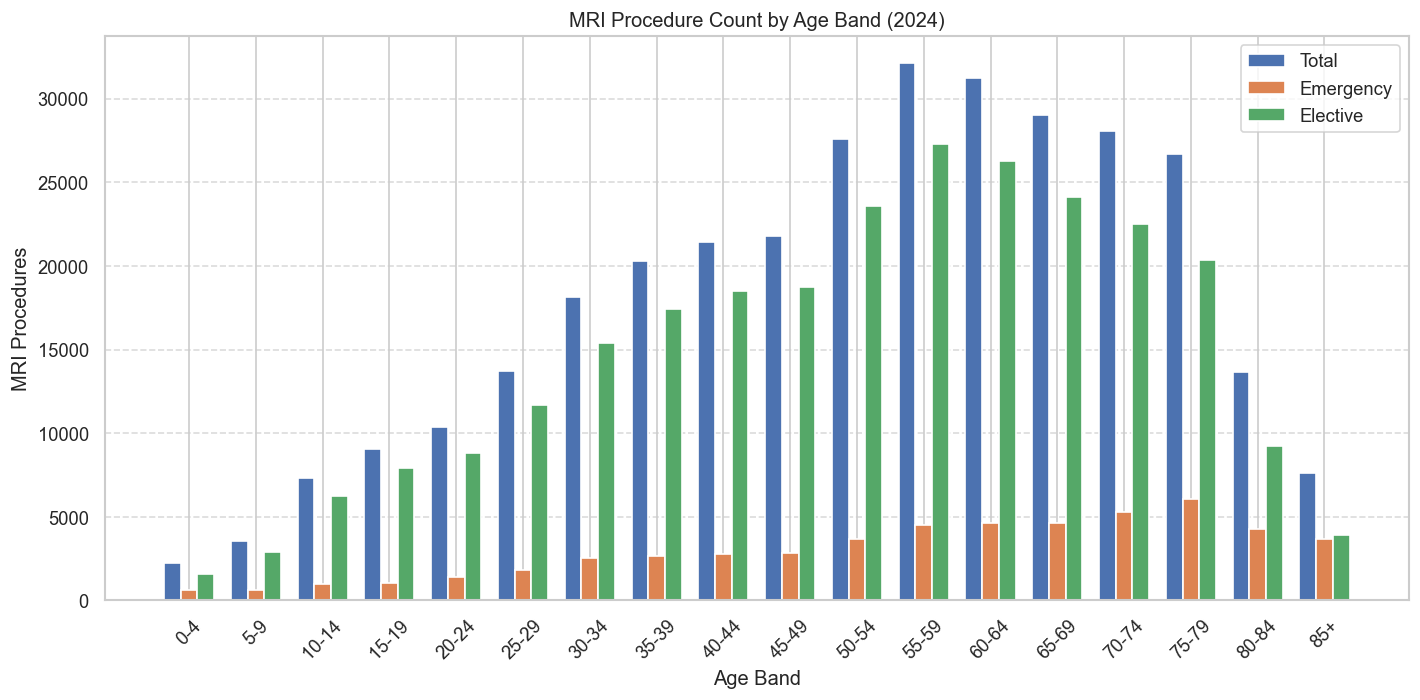

In [7]:
# ---- Step 4.1: Plot Raw MRI Procedure Counts by Age Band ----

plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(mri_naive_df['age_band']))

plt.bar(x - bar_width, mri_naive_df['MRI_Total'], width=bar_width, label='Total')
plt.bar(x, mri_naive_df['MRI_Emergency'], width=bar_width, label='Emergency')
plt.bar(x + bar_width, mri_naive_df['MRI_Elective'], width=bar_width, label='Elective')

plt.xlabel("Age Band")
plt.ylabel("MRI Procedures")
plt.title("MRI Procedure Count by Age Band (2024)")
plt.xticks(x, mri_naive_df['age_band'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


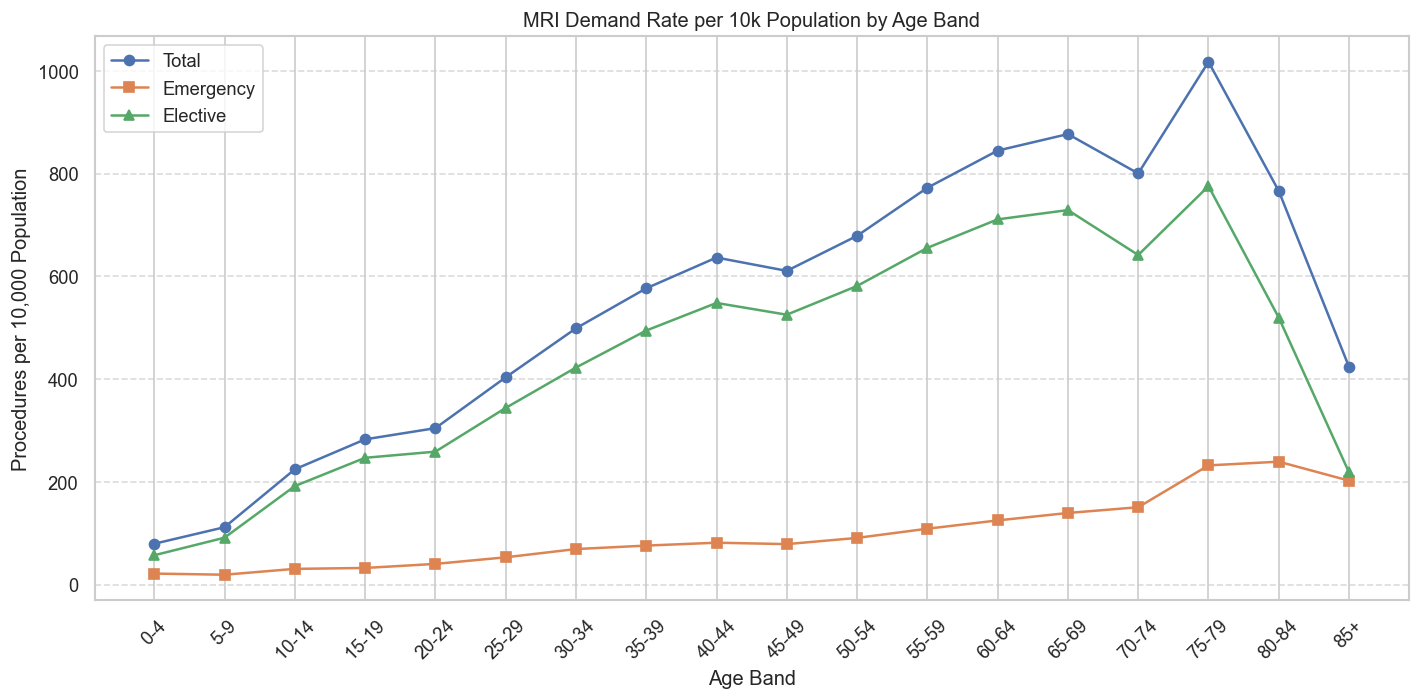

In [8]:
# ---- Step 4.2: Plot MRI Rate per 10,000 Population by Age Band ----

plt.figure(figsize=(12, 6))

plt.plot(mri_naive_df['age_band'], mri_naive_df['mri_total_per_10k'], label='Total', marker='o')
plt.plot(mri_naive_df['age_band'], mri_naive_df['mri_emergency_per_10k'], label='Emergency', marker='s')
plt.plot(mri_naive_df['age_band'], mri_naive_df['mri_elective_per_10k'], label='Elective', marker='^')

plt.xlabel("Age Band")
plt.ylabel("Procedures per 10,000 Population")
plt.title("MRI Demand Rate per 10k Population by Age Band")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# ---- Step 4.3 (Revised): Convert to PDFs proportionate to total ----

# Step 1: Calculate demand volumes
mri_naive_df["demand_total"] = (
    mri_naive_df["mri_total_per_1k"] * mri_naive_df["population_2024"]
) / 1000
mri_naive_df["demand_emergency"] = (
    mri_naive_df["mri_emergency_per_1k"] * mri_naive_df["population_2024"]
) / 1000
mri_naive_df["demand_elective"] = (
    mri_naive_df["mri_elective_per_1k"] * mri_naive_df["population_2024"]
) / 1000

# Step 2: Normalise everything using the **total demand** sum
total_sum = mri_naive_df["demand_total"].sum()

mri_naive_df["pdf_total"] = mri_naive_df["demand_total"] / total_sum
mri_naive_df["pdf_emergency"] = mri_naive_df["demand_emergency"] / total_sum
mri_naive_df["pdf_elective"] = mri_naive_df["demand_elective"] / total_sum

# Step 3: Confirm proportions relative to total
print(
    f"PDF sums (all proportion of total): "
    f"total={mri_naive_df['pdf_total'].sum():.6f}, "
    f"emergency={mri_naive_df['pdf_emergency'].sum():.6f}, "
    f"elective={mri_naive_df['pdf_elective'].sum():.6f}"
)


PDF sums (all proportion of total): total=1.000000, emergency=0.166378, elective=0.822668


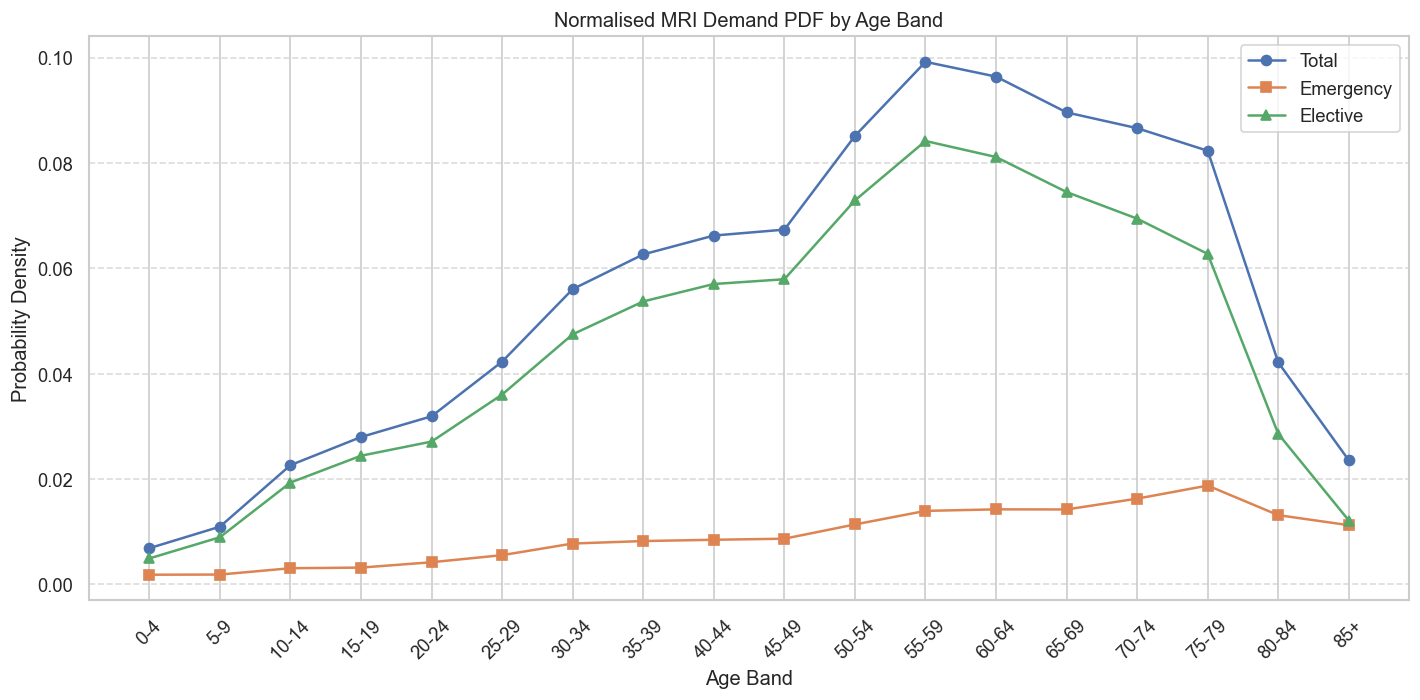

In [10]:
# ---- Step 4.4: Plot PDF of MRI Demand by Age Band ----

plt.figure(figsize=(12, 6))

plt.plot(mri_naive_df['age_band'], mri_naive_df['pdf_total'], label='Total', marker='o')
plt.plot(mri_naive_df['age_band'], mri_naive_df['pdf_emergency'], label='Emergency', marker='s')
plt.plot(mri_naive_df['age_band'], mri_naive_df['pdf_elective'], label='Elective', marker='^')

plt.xlabel("Age Band")
plt.ylabel("Probability Density")
plt.title("Normalised MRI Demand PDF by Age Band")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


   age  population_2024  MRI_Total  mri_total_per_1k  MRI_Emergency  \
0  0.0          52166.0      983.0             18.84          590.0   
1  1.0          54517.0      424.0              7.78          133.0   
2  2.0          56664.0      393.0              6.94          109.0   
3  3.0          57911.0      428.0              7.39          117.0   
4  4.0          59455.0      461.0              7.75          140.0   

   mri_emergency_per_1k  MRI_Elective  mri_elective_per_1k  
0                 11.31         393.0                 7.53  
1                  2.44         291.0                 5.34  
2                  1.92         284.0                 5.01  
3                  2.02         311.0                 5.37  
4                  2.35         321.0                 5.40  


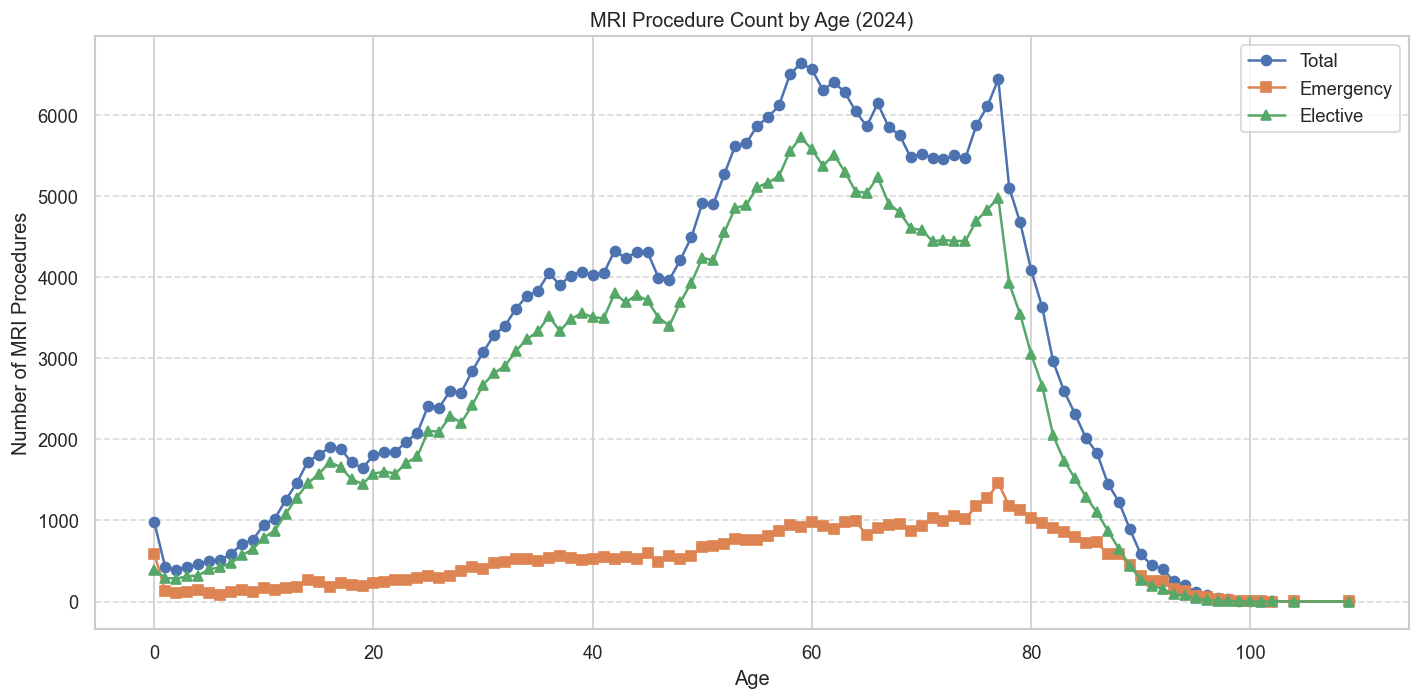

In [11]:
# ------------------------------------------------------------
# Step 5: Naïve Model (Continuous Age) for MRI: Total, Emergency, Elective
# ------------------------------------------------------------

# Step 5.1: Filter MRI records
mri_df_cont = mri_master_df[mri_master_df["is_mri"] == 1].copy()

# Step 5.2: Define and apply patient source classification
def classify_source(ps):
    emergency_sources = [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)",
    ]
    elective_sources = [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)",
    ]

    if ps in emergency_sources:
        return "Emergency"
    elif ps in elective_sources:
        return "Elective"
    return "Other"

if "source_group" not in mri_df_cont.columns:
    mri_df_cont["source_group"] = mri_df_cont["patient_source"].map(classify_source)

# Step 5.3: Add exam_count = 1 if missing
if "exam_count" not in mri_df_cont.columns:
    mri_df_cont["exam_count"] = 1

# Step 5.4: Aggregate MRI exams by age and source group
mri_by_age_source = (
    mri_df_cont
    .groupby(["age", "source_group"])["exam_count"]
    .sum()
    .reset_index()
    .pivot(index="age", columns="source_group", values="exam_count")
    .fillna(0)
    .reset_index()
    .rename(columns={
        "Emergency": "MRI_Emergency",
        "Elective": "MRI_Elective"
    })
)

# Step 5.5: Add total MRI column
mri_by_age_source["MRI_Total"] = (
    mri_by_age_source["MRI_Emergency"] + mri_by_age_source["MRI_Elective"]
)

# Step 5.6: Load and rename population data
population_df = pd.read_csv(population_path)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Step 5.7: Merge MRI data with population
merged_df = mri_by_age_source.merge(population_df, on="age", how="left")

# Step 5.8: Calculate per 1,000 and per 10,000 rates
for col in ["MRI_Total", "MRI_Emergency", "MRI_Elective"]:
    merged_df[f"{col.lower()}_per_10k"] = (
        merged_df[col] / merged_df["population_2024"] * 10000
    )
    merged_df[f"{col.lower()}_per_1k"] = (
        merged_df[col] / merged_df["population_2024"] * 1000
    )

# Step 5.9: Compute Emergency/Elective proportion of total
merged_df["pct_emergency_of_total"] = np.where(
    merged_df["MRI_Total"] > 0,
    merged_df["MRI_Emergency"] / merged_df["MRI_Total"] * 100,
    0
)

merged_df["pct_elective_of_total"] = np.where(
    merged_df["MRI_Total"] > 0,
    merged_df["MRI_Elective"] / merged_df["MRI_Total"] * 100,
    0
)

# Step 5.10: Round percentages for clarity
merged_df[["pct_emergency_of_total", "pct_elective_of_total"]] = (
    merged_df[["pct_emergency_of_total", "pct_elective_of_total"]].round(1)
)

# Step 5.11: Round rates for display
rate_cols = [col for col in merged_df.columns if "_per_" in col]
merged_df[rate_cols] = merged_df[rate_cols].round(2)

# Step 5.12: Sort by age
merged_df = merged_df.sort_values("age").reset_index(drop=True)

# Step 5.13: Display preview
print(
    merged_df[
        ["age", "population_2024", "MRI_Total", "mri_total_per_1k",
         "MRI_Emergency", "mri_emergency_per_1k",
         "MRI_Elective", "mri_elective_per_1k"]
    ].head()
)

# Step 5.14: Plot Total, Emergency, and Elective MRI Counts by Age
# Shows total number of MRI procedures by age, split by emergency and elective pathways.
plt.figure(figsize=(12, 6))
plt.plot(merged_df["age"], merged_df["MRI_Total"], label="Total", marker="o")
plt.plot(merged_df["age"], merged_df["MRI_Emergency"], label="Emergency", marker="s")
plt.plot(merged_df["age"], merged_df["MRI_Elective"], label="Elective", marker="^")

plt.xlabel("Age")
plt.ylabel("Number of MRI Procedures")
plt.title("MRI Procedure Count by Age (2024)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


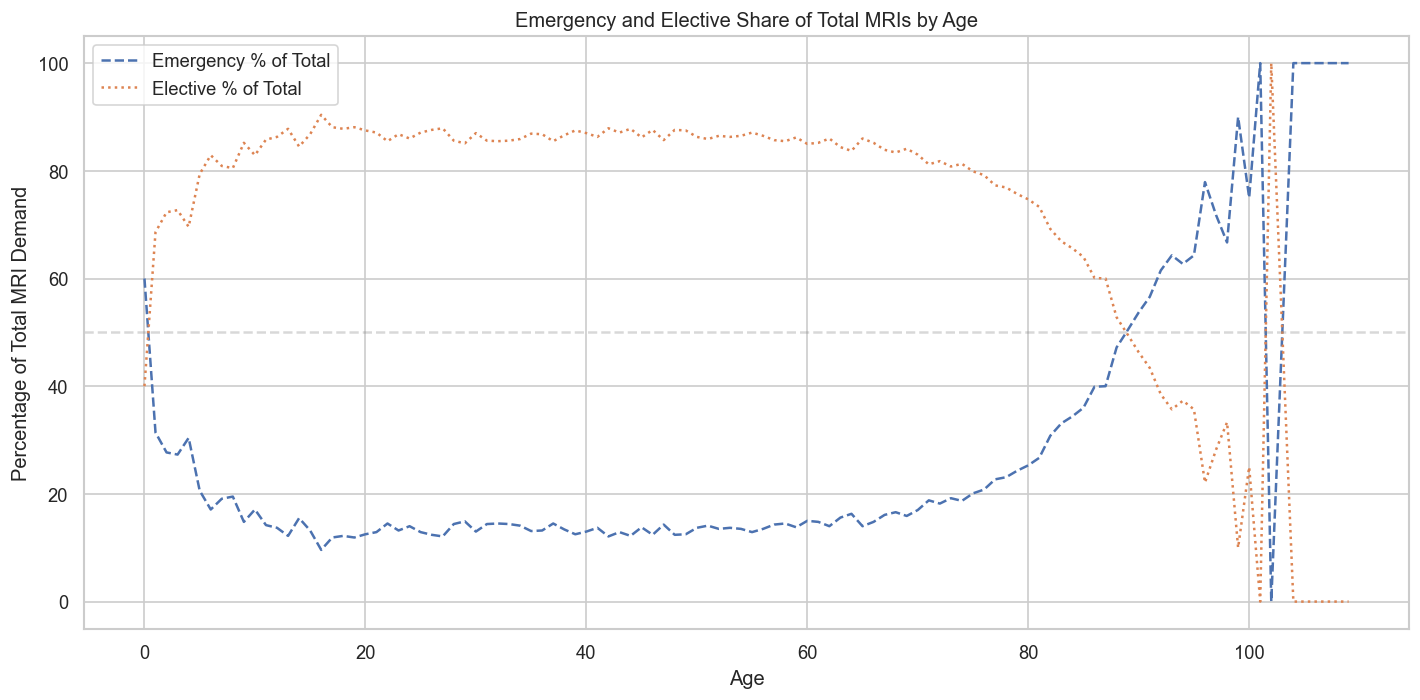

In [12]:
# Step 5.15: Plot Emergency and Elective Share of Total MRIs by Age
# Shows the proportion of total MRI demand that is emergency or elective, by age.
plt.figure(figsize=(12, 6))
plt.plot(
    merged_df["age"],
    merged_df["pct_emergency_of_total"],
    label="Emergency % of Total",
    linestyle="--"
)
plt.plot(
    merged_df["age"],
    merged_df["pct_elective_of_total"],
    label="Elective % of Total",
    linestyle=":"
)
plt.axhline(50, color="grey", linestyle="--", alpha=0.3)

plt.xlabel("Age")
plt.ylabel("Percentage of Total MRI Demand")
plt.title("Emergency and Elective Share of Total MRIs by Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


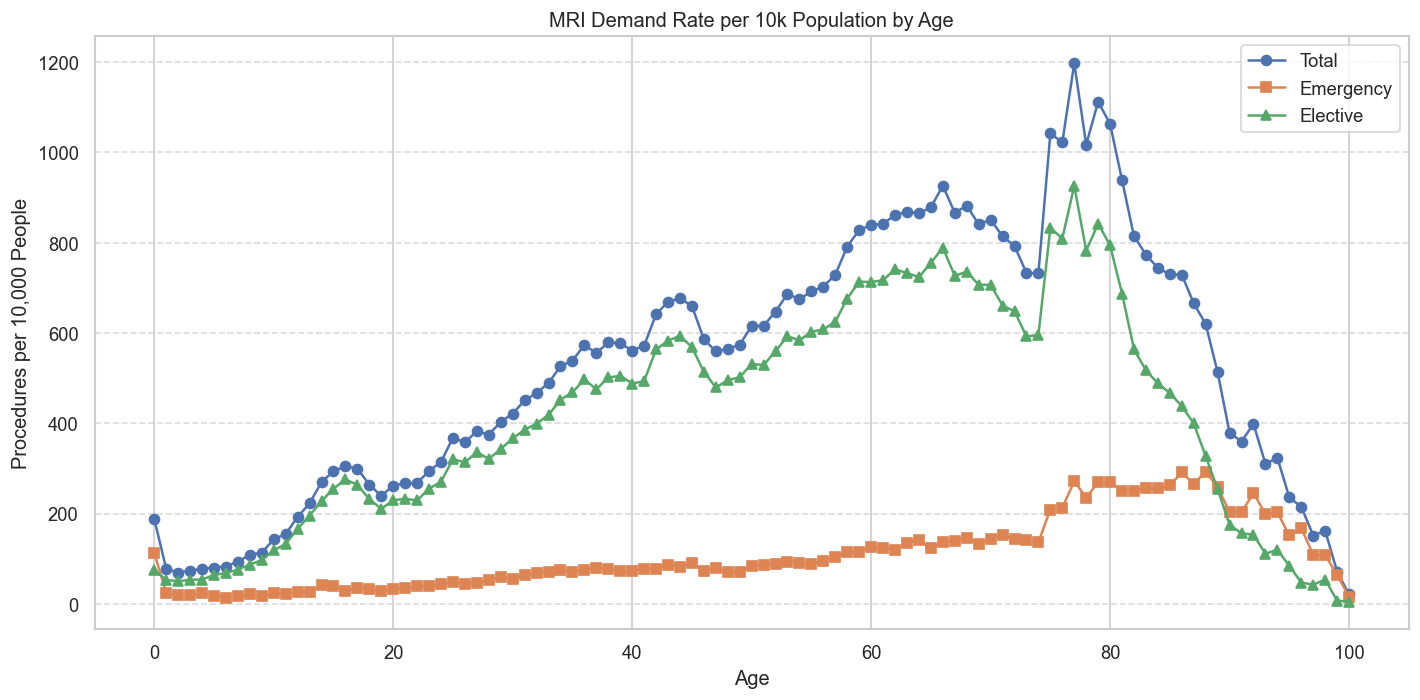

In [13]:
# Step 5.16: Plot MRI Demand Rates per 10,000 People by Age
# Displays standardised MRI demand per 10,000 population by age for all categories.
plt.figure(figsize=(12, 6))
plt.plot(merged_df["age"], merged_df["mri_total_per_10k"], label="Total", marker="o")
plt.plot(merged_df["age"], merged_df["mri_emergency_per_10k"], label="Emergency", marker="s")
plt.plot(merged_df["age"], merged_df["mri_elective_per_10k"], label="Elective", marker="^")

plt.xlabel("Age")
plt.ylabel("Procedures per 10,000 People")
plt.title("MRI Demand Rate per 10k Population by Age")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


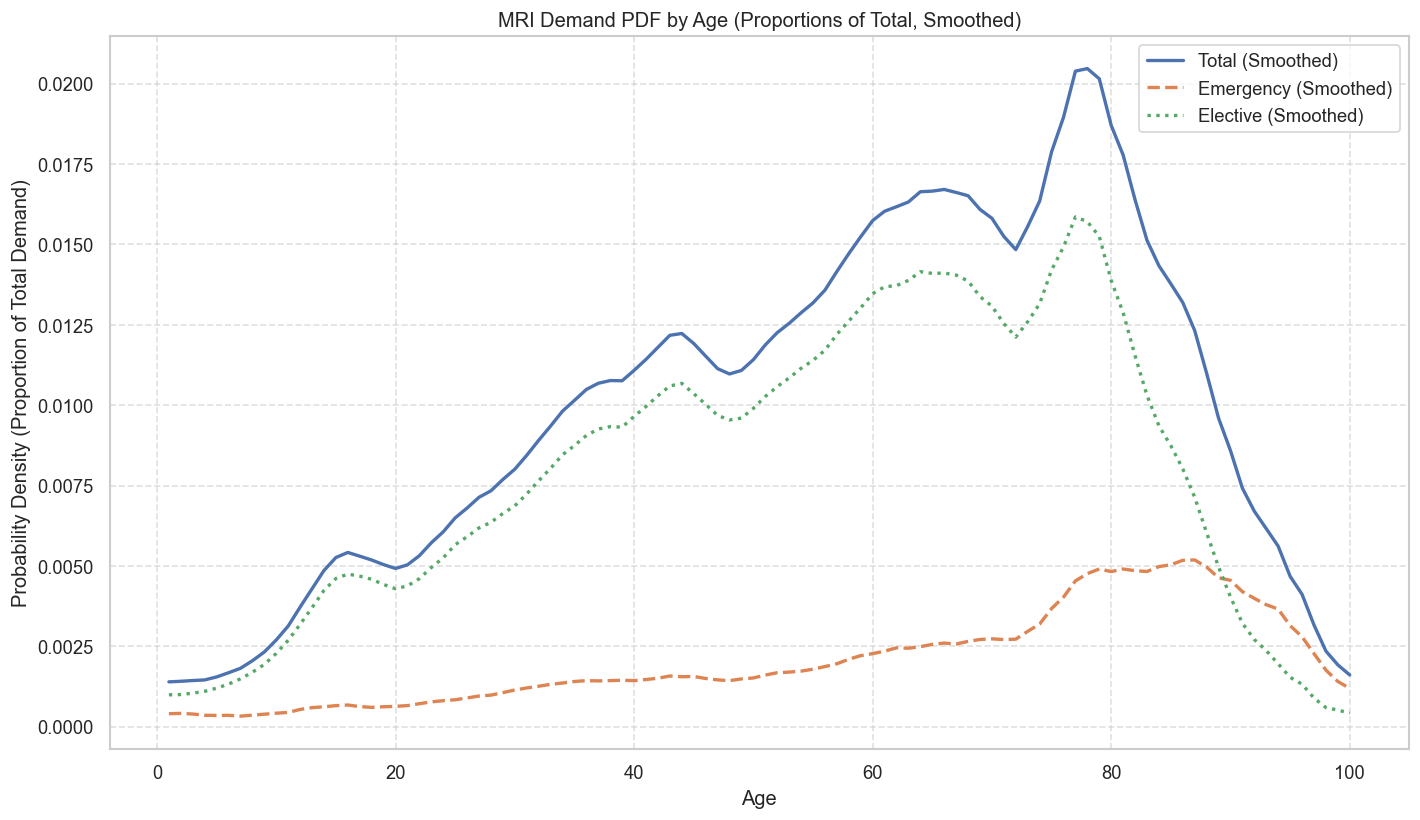

In [14]:
# Step 5.17: Prepare Continuous Age Range and Merge with MRI Demand Rates
# Ensures complete age coverage (1–100) by merging with per 1k demand data and filling missing ages with 0s.
full_age_range = pd.DataFrame({"age": np.arange(1, 101)})

cols_to_merge = [
    "age",
    "mri_total_per_1k",
    "mri_emergency_per_1k",
    "mri_elective_per_1k"
]

merged_all = (
    full_age_range
    .merge(merged_df[cols_to_merge], on="age", how="left")
    .fillna(0)
)

# Step 5.18: Estimate Raw Demand and Normalise to Shared PDF
# Converts per 1k rates to raw demand proxy and normalises each category into a probability density function.
merged_all["total_demand"] = merged_all["mri_total_per_1k"]
merged_all["emergency_demand"] = merged_all["mri_emergency_per_1k"]
merged_all["elective_demand"] = merged_all["mri_elective_per_1k"]

total_demand_sum = merged_all["total_demand"].sum()

merged_all["pdf_total"] = merged_all["total_demand"] / total_demand_sum
merged_all["pdf_emergency"] = merged_all["emergency_demand"] / total_demand_sum
merged_all["pdf_elective"] = merged_all["elective_demand"] / total_demand_sum

# Step 5.19: Apply Moving Average Smoothing to PDFs
# Smooths the probability density functions using a 5-year rolling average for visual clarity.
window = 5
for col in ["pdf_total", "pdf_emergency", "pdf_elective"]:
    merged_all[f"{col}_smoothed"] = (
        merged_all[col]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

# Step 5.20: Plot Smoothed PDFs by Age
# Visualises the smoothed probability densities to show the age distribution of MRI demand across categories.
plt.figure(figsize=(12, 7))
plt.plot(merged_all["age"], merged_all["pdf_total_smoothed"], label="Total (Smoothed)", linewidth=2)
plt.plot(merged_all["age"], merged_all["pdf_emergency_smoothed"], label="Emergency (Smoothed)", linestyle="--", linewidth=2)
plt.plot(merged_all["age"], merged_all["pdf_elective_smoothed"], label="Elective (Smoothed)", linestyle=":", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Probability Density (Proportion of Total Demand)")
plt.title("MRI Demand PDF by Age (Proportions of Total, Smoothed)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


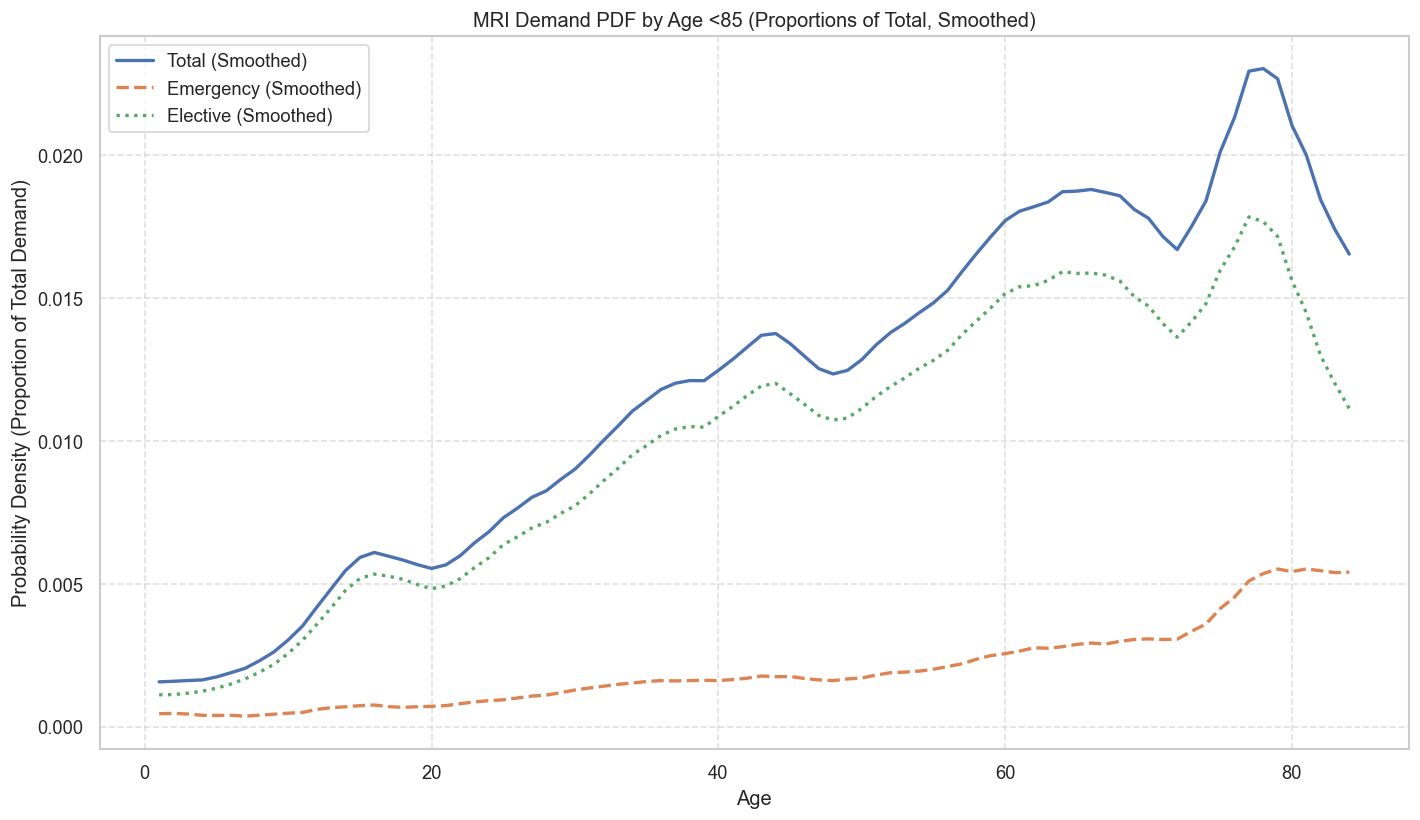

In [15]:
# ------------------------------------------------------------
# Step 6: MRI Demand PDF (Age <85 Only) — Total, Emergency, Elective
# ------------------------------------------------------------

# Step 6.1: Filter to age <85 and create continuous age range
# Focuses analysis on MRI demand up to age 84, removing extreme age noise or small-n effects.
full_age_range_lt85 = pd.DataFrame({"age": np.arange(1, 85)})

cols_to_merge = [
    "age",
    "mri_total_per_1k",
    "mri_emergency_per_1k",
    "mri_elective_per_1k"
]

merged_lt85 = (
    full_age_range_lt85
    .merge(merged_df[cols_to_merge], on="age", how="left")
    .fillna(0)
)

# Step 6.2: Estimate raw demand and compute PDFs (<85 only)
# Converts per 1k rates into age-specific proportions of overall demand.
merged_lt85["total_demand"] = merged_lt85["mri_total_per_1k"]
merged_lt85["emergency_demand"] = merged_lt85["mri_emergency_per_1k"]
merged_lt85["elective_demand"] = merged_lt85["mri_elective_per_1k"]

total_demand_lt85 = merged_lt85["total_demand"].sum()

merged_lt85["pdf_total"] = merged_lt85["total_demand"] / total_demand_lt85
merged_lt85["pdf_emergency"] = merged_lt85["emergency_demand"] / total_demand_lt85
merged_lt85["pdf_elective"] = merged_lt85["elective_demand"] / total_demand_lt85

# Step 6.3: Apply smoothing to the <85 PDFs
# Uses a centred 5-year moving average to smooth noisy patterns and emphasise trend structure.
for col in ["pdf_total", "pdf_emergency", "pdf_elective"]:
    merged_lt85[f"{col}_smoothed"] = (
        merged_lt85[col]
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

# Step 6.4: Plot Smoothed PDFs (Age <85)
# Visualises the proportion of total MRI demand attributable to each age for <85 population.
plt.figure(figsize=(12, 7))
plt.plot(merged_lt85["age"], merged_lt85["pdf_total_smoothed"], label="Total (Smoothed)", linewidth=2)
plt.plot(merged_lt85["age"], merged_lt85["pdf_emergency_smoothed"], label="Emergency (Smoothed)", linestyle="--", linewidth=2)
plt.plot(merged_lt85["age"], merged_lt85["pdf_elective_smoothed"], label="Elective (Smoothed)", linestyle=":", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Probability Density (Proportion of Total Demand)")
plt.title("MRI Demand PDF by Age <85 (Proportions of Total, Smoothed)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Emergency GLM (Smoothed)       | MAE: 2.87 | RMSE: 5.06 | R²: 0.585
Emergency RF (Smoothed)        | MAE: 0.81 | RMSE: 1.36 | R²: 0.970
Emergency Ensemble (Smoothed)  | MAE: 1.94 | RMSE: 3.36 | R²: 0.817


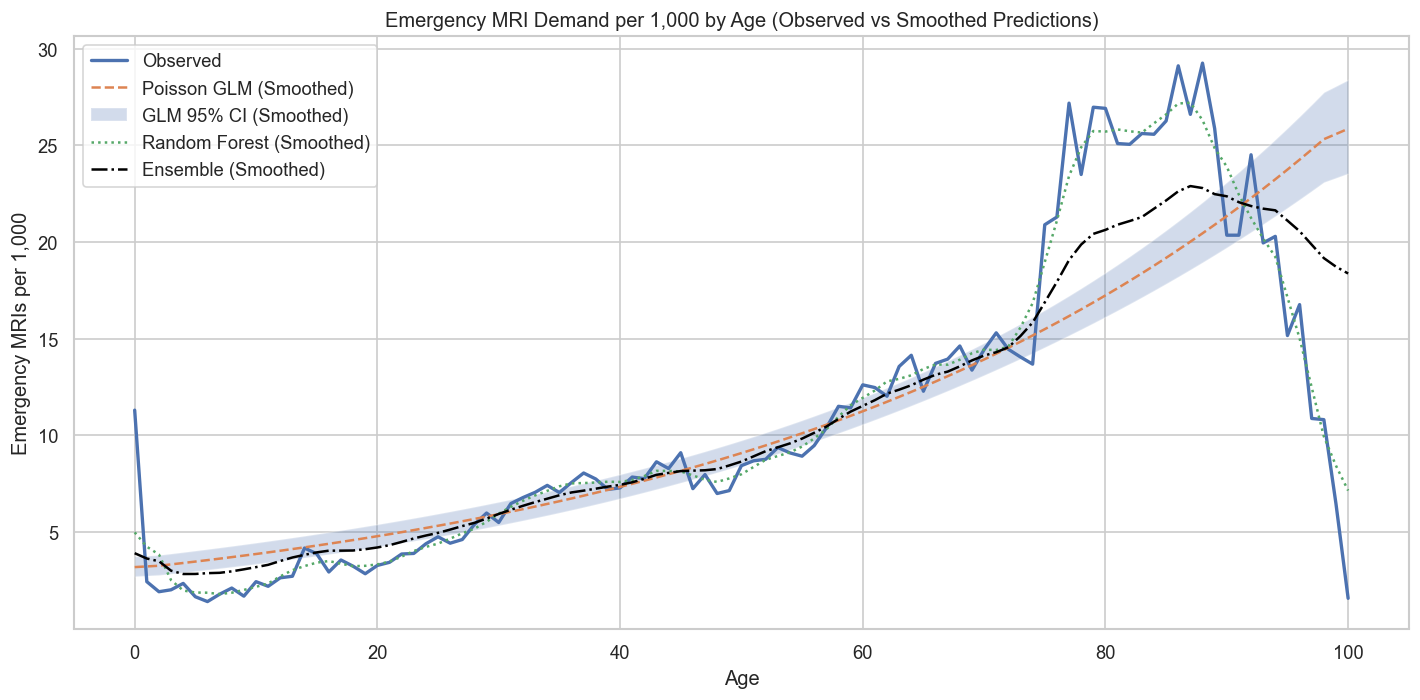

In [16]:
# ------------------------------------------------------------
# Step 7: Model Forecasting – Emergency MRI Demand per 1,000
# ------------------------------------------------------------

# Step 7.1: Define evaluation function
def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<30} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

# Step 7.2: Prepare emergency MRI dataset
# Subsets the data to valid emergency MRI rates.
model_df_em = merged_df.copy()
model_df_em.dropna(subset=["mri_emergency_per_1k"], inplace=True)

# Step 7.3: Fit Poisson Generalised Linear Model (GLM)
glm_em = smf.glm("mri_emergency_per_1k ~ age", data=model_df_em, family=sm.families.Poisson()).fit()
model_df_em["predicted_glm"] = glm_em.predict(model_df_em)
ci_em = glm_em.get_prediction(model_df_em).summary_frame()
model_df_em["glm_ci_lower"] = ci_em["mean_ci_lower"]
model_df_em["glm_ci_upper"] = ci_em["mean_ci_upper"]

# Step 7.4: Fit Random Forest Regressor
rf_em = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em.fit(model_df_em[["age"]], model_df_em["mri_emergency_per_1k"])
model_df_em["predicted_rf"] = rf_em.predict(model_df_em[["age"]])

# Step 7.5: Combine Ensemble Model (weighted average of GLM and RF)
model_df_em["predicted_ensemble"] = (
    0.6 * model_df_em["predicted_glm"] + 0.4 * model_df_em["predicted_rf"]
)

# Step 7.6: Apply moving average smoothing (window=5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df_em[f"{col}_smoothed"] = (
        model_df_em[col]
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

model_df_em["glm_ci_lower_smoothed"] = model_df_em["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_em["glm_ci_upper_smoothed"] = model_df_em["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Step 7.7: Evaluate each model's accuracy
evaluate(model_df_em["mri_emergency_per_1k"], model_df_em["predicted_glm_smoothed"], "Emergency GLM (Smoothed)")
evaluate(model_df_em["mri_emergency_per_1k"], model_df_em["predicted_rf_smoothed"],  "Emergency RF (Smoothed)")
evaluate(model_df_em["mri_emergency_per_1k"], model_df_em["predicted_ensemble_smoothed"], "Emergency Ensemble (Smoothed)")

# Step 7.8: Plot observed vs predicted emergency MRI demand
plt.figure(figsize=(12, 6))

# Observed emergency rate
sns.lineplot(data=model_df_em, x="age", y="mri_emergency_per_1k", label="Observed", linewidth=2)

# Smoothed GLM prediction + confidence interval
sns.lineplot(data=model_df_em, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(model_df_em["age"], model_df_em["glm_ci_lower_smoothed"], model_df_em["glm_ci_upper_smoothed"],
                 alpha=0.25, label="GLM 95% CI (Smoothed)")

# Random Forest prediction
sns.lineplot(data=model_df_em, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")

# Ensemble prediction
sns.lineplot(data=model_df_em, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

# Final plot formatting
plt.title("Emergency MRI Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Emergency MRIs per 1,000")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Elective GLM (Smoothed)        | MAE: 19.61 | RMSE: 23.75 | R²: 0.070
Elective RF (Smoothed)         | MAE: 1.69 | RMSE: 2.59 | R²: 0.989
Elective Ensemble (Smoothed)   | MAE: 11.88 | RMSE: 14.58 | R²: 0.649


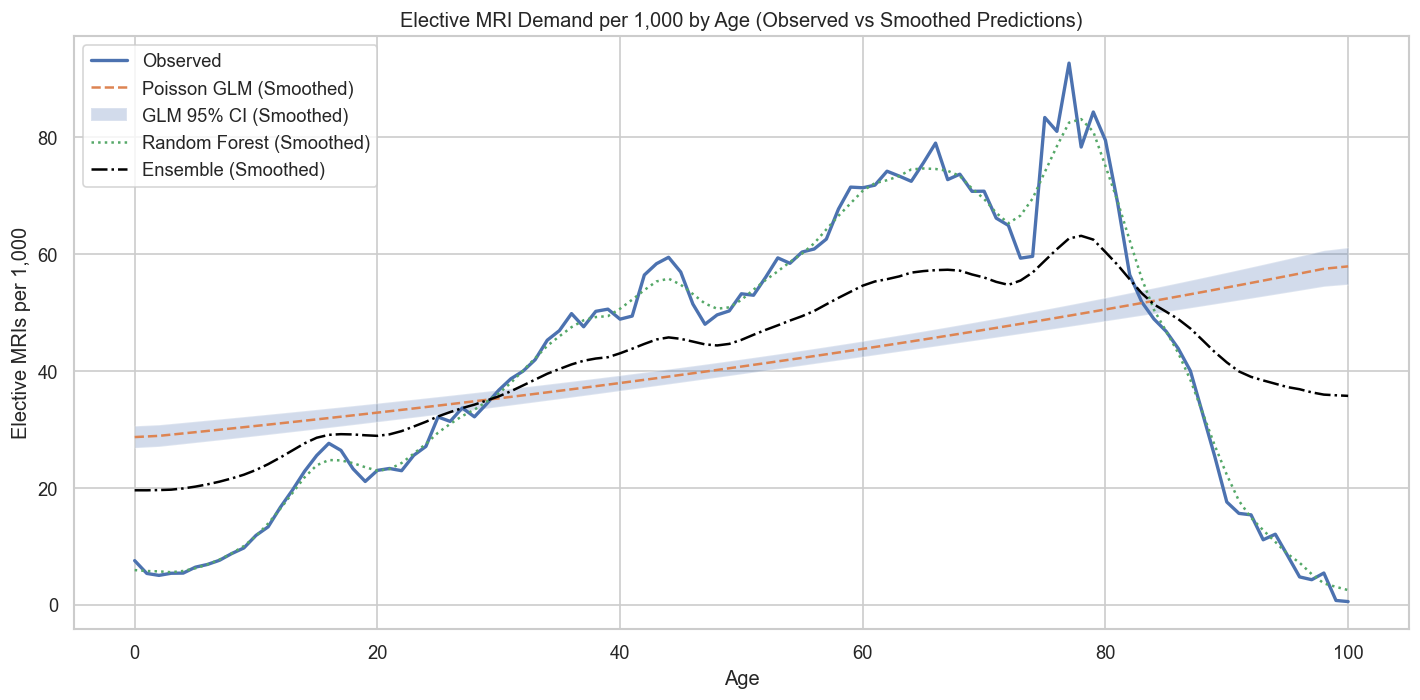

In [17]:
# ------------------------------------------------------------
# Step 8: Model Forecasting – Elective MRI Demand per 1,000
# ------------------------------------------------------------

# Step 8.1: Prepare elective MRI dataset
# Subsets to valid elective MRI rates by age
model_df_el = merged_df.copy()
model_df_el.dropna(subset=["mri_elective_per_1k"], inplace=True)

# Step 8.2: Fit Poisson Generalised Linear Model (GLM)
glm_el = smf.glm("mri_elective_per_1k ~ age", data=model_df_el, family=sm.families.Poisson()).fit()
model_df_el["predicted_glm"] = glm_el.predict(model_df_el)
ci_el = glm_el.get_prediction(model_df_el).summary_frame()
model_df_el["glm_ci_lower"] = ci_el["mean_ci_lower"]
model_df_el["glm_ci_upper"] = ci_el["mean_ci_upper"]

# Step 8.3: Fit Random Forest Regressor
rf_el = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el.fit(model_df_el[["age"]], model_df_el["mri_elective_per_1k"])
model_df_el["predicted_rf"] = rf_el.predict(model_df_el[["age"]])

# Step 8.4: Combine Ensemble Model (60% GLM + 40% RF)
model_df_el["predicted_ensemble"] = (
    0.6 * model_df_el["predicted_glm"] + 0.4 * model_df_el["predicted_rf"]
)

# Step 8.5: Apply moving average smoothing (window=5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df_el[f"{col}_smoothed"] = (
        model_df_el[col]
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

model_df_el["glm_ci_lower_smoothed"] = model_df_el["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_el["glm_ci_upper_smoothed"] = model_df_el["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Step 8.6: Evaluate model performance
evaluate(model_df_el["mri_elective_per_1k"], model_df_el["predicted_glm_smoothed"], "Elective GLM (Smoothed)")
evaluate(model_df_el["mri_elective_per_1k"], model_df_el["predicted_rf_smoothed"],  "Elective RF (Smoothed)")
evaluate(model_df_el["mri_elective_per_1k"], model_df_el["predicted_ensemble_smoothed"], "Elective Ensemble (Smoothed)")

# Step 8.7: Plot observed vs predicted elective MRI demand
plt.figure(figsize=(12, 6))

# Observed elective rate
sns.lineplot(data=model_df_el, x="age", y="mri_elective_per_1k", label="Observed", linewidth=2)

# Smoothed GLM prediction + confidence interval
sns.lineplot(data=model_df_el, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(model_df_el["age"], model_df_el["glm_ci_lower_smoothed"], model_df_el["glm_ci_upper_smoothed"],
                 alpha=0.25, label="GLM 95% CI (Smoothed)")

# Random Forest prediction
sns.lineplot(data=model_df_el, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")

# Ensemble prediction
sns.lineplot(data=model_df_el, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

# Final plot formatting
plt.title("Elective MRI Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Elective MRIs per 1,000")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# ------------------------------------------------------------
# Step 9: GLM Summary Outputs for Emergency and Elective MRI
# ------------------------------------------------------------

# Step 9.1: Emergency GLM
# Fit Poisson GLM to emergency MRI demand per 1,000 by age
model_df_em = merged_df.copy()
model_df_em.dropna(subset=["mri_emergency_per_1k"], inplace=True)

glm_em = smf.glm(
    formula="mri_emergency_per_1k ~ age",
    data=model_df_em,
    family=sm.families.Poisson()
).fit()

# Step 9.2: Elective GLM
# Fit Poisson GLM to elective MRI demand per 1,000 by age
model_df_el = merged_df.copy()
model_df_el.dropna(subset=["mri_elective_per_1k"], inplace=True)

glm_el = smf.glm(
    formula="mri_elective_per_1k ~ age",
    data=model_df_el,
    family=sm.families.Poisson()
).fit()

# Step 9.3: Print GLM Summaries
print("----- Emergency MRI Poisson GLM Summary -----")
print(glm_em.summary())

print("\n----- Elective MRI Poisson GLM Summary -----")
print(glm_el.summary())


----- Emergency MRI Poisson GLM Summary -----
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mri_emergency_per_1k   No. Observations:                  101
Model:                              GLM   Df Residuals:                       99
Model Family:                   Poisson   Df Model:                            1
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -283.15
Date:                  Mon, 07 Jul 2025   Deviance:                       165.56
Time:                          16:01:27   Pearson chi2:                     150.
No. Iterations:                       4   Pseudo R-squ. (CS):             0.9777
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [19]:
# ------------------------------------------------------------
# Step 10: GLM Models for Age < 85 — Emergency and Elective MRI
# ------------------------------------------------------------

# Step 10.1: Emergency GLM for Age < 85
# Fits Poisson GLM to emergency MRI demand per 1,000 by age (age < 85)

model_df_em_lt85 = merged_df[merged_df["age"] < 85].copy()
model_df_em_lt85.dropna(subset=["mri_emergency_per_1k"], inplace=True)

glm_em_lt85 = smf.glm(
    formula="mri_emergency_per_1k ~ age",
    data=model_df_em_lt85,
    family=sm.families.Poisson()
).fit()

print("----- Emergency MRI Poisson GLM (Age < 85) -----")
print(glm_em_lt85.summary())


# Step 10.2: Elective GLM for Age < 85
# Fits Poisson GLM to elective MRI demand per 1,000 by age (age < 85)

model_df_el_lt85 = merged_df[merged_df["age"] < 85].copy()
model_df_el_lt85.dropna(subset=["mri_elective_per_1k"], inplace=True)

glm_el_lt85 = smf.glm(
    formula="mri_elective_per_1k ~ age",
    data=model_df_el_lt85,
    family=sm.families.Poisson()
).fit()

print("\n----- Elective MRI Poisson GLM (Age < 85) -----")
print(glm_el_lt85.summary())


----- Emergency MRI Poisson GLM (Age < 85) -----
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mri_emergency_per_1k   No. Observations:                   85
Model:                              GLM   Df Residuals:                       83
Model Family:                   Poisson   Df Model:                            1
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -182.14
Date:                  Mon, 07 Jul 2025   Deviance:                       37.610
Time:                          16:01:59   Pearson chi2:                     56.0
No. Iterations:                       5   Pseudo R-squ. (CS):             0.9836
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

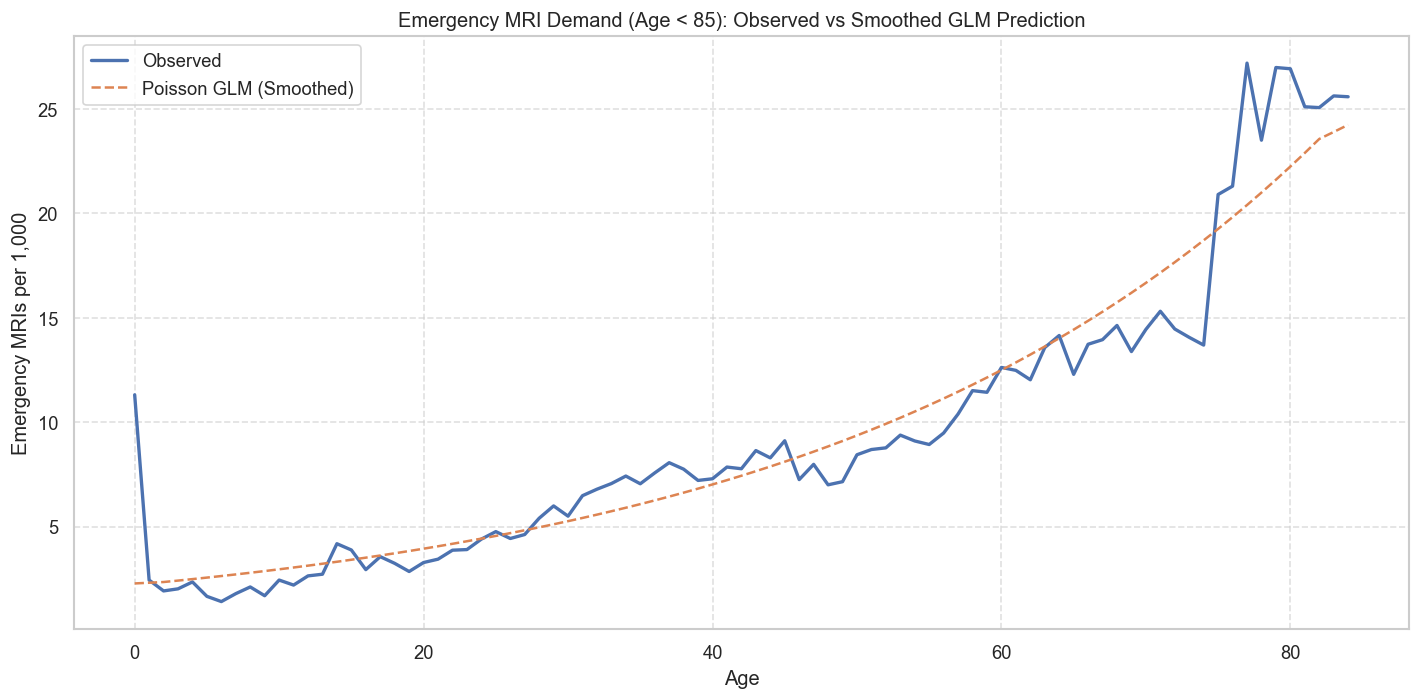

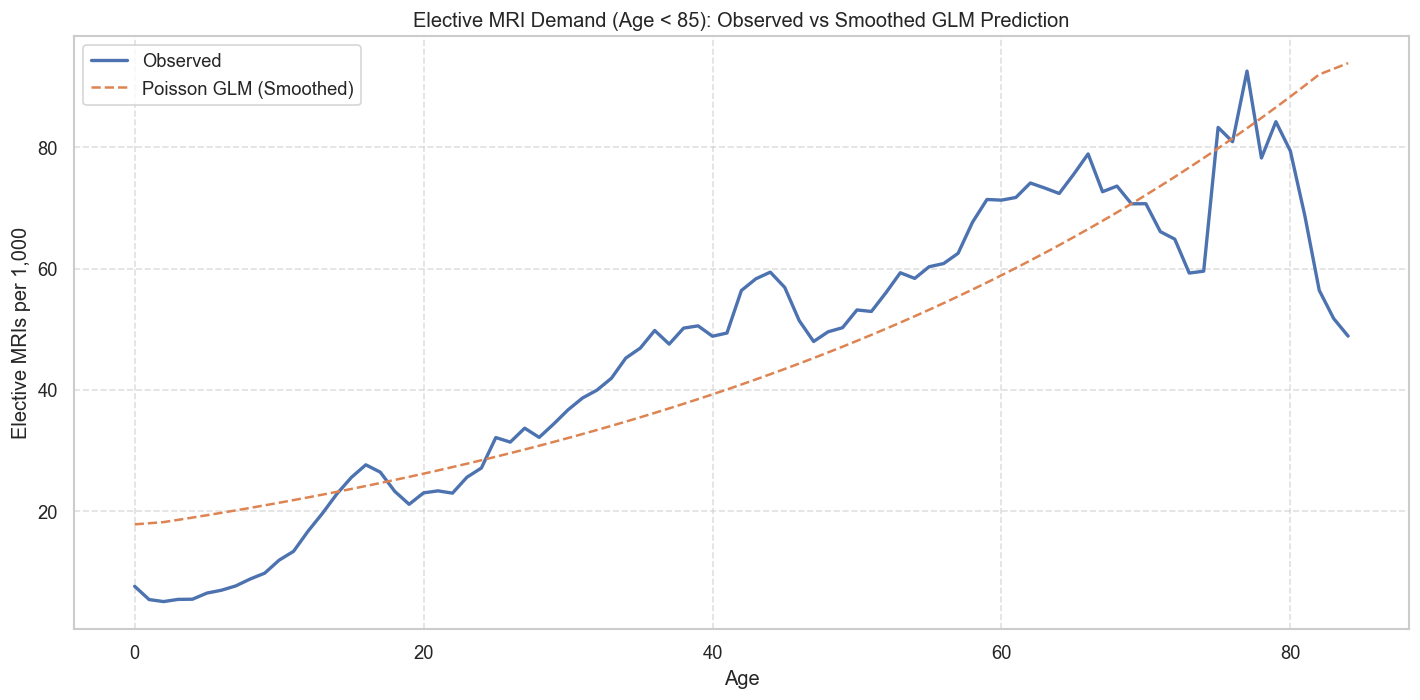

In [20]:
# ------------------------------------------------------------
# Step 10.3: Visualise GLM Predictions for MRI (Age < 85)
# ------------------------------------------------------------

# Emergency: Predict + Smooth
model_df_em_lt85["predicted_glm"] = glm_em_lt85.predict(model_df_em_lt85)
model_df_em_lt85["predicted_glm_smoothed"] = (
    model_df_em_lt85["predicted_glm"].rolling(window=5, center=True, min_periods=1).mean()
)

# Elective: Predict + Smooth
model_df_el_lt85["predicted_glm"] = glm_el_lt85.predict(model_df_el_lt85)
model_df_el_lt85["predicted_glm_smoothed"] = (
    model_df_el_lt85["predicted_glm"].rolling(window=5, center=True, min_periods=1).mean()
)

# Plot: Emergency
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_em_lt85, x="age", y="mri_emergency_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.title("Emergency MRI Demand (Age < 85): Observed vs Smoothed GLM Prediction")
plt.ylabel("Emergency MRIs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Elective
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_el_lt85, x="age", y="mri_elective_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.title("Elective MRI Demand (Age < 85): Observed vs Smoothed GLM Prediction")
plt.ylabel("Elective MRIs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# ------------------------------------------------------------
# Step 10.4: Add Confidence Intervals, RF, and Ensemble Predictions (MRI <85)
# ------------------------------------------------------------

# Emergency — GLM Confidence Intervals
ci_em_lt85 = glm_em_lt85.get_prediction(model_df_em_lt85).summary_frame()
model_df_em_lt85["glm_ci_lower"] = ci_em_lt85["mean_ci_lower"]
model_df_em_lt85["glm_ci_upper"] = ci_em_lt85["mean_ci_upper"]
model_df_em_lt85["glm_ci_lower_smoothed"] = model_df_em_lt85["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_em_lt85["glm_ci_upper_smoothed"] = model_df_em_lt85["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Elective — GLM Confidence Intervals
ci_el_lt85 = glm_el_lt85.get_prediction(model_df_el_lt85).summary_frame()
model_df_el_lt85["glm_ci_lower"] = ci_el_lt85["mean_ci_lower"]
model_df_el_lt85["glm_ci_upper"] = ci_el_lt85["mean_ci_upper"]
model_df_el_lt85["glm_ci_lower_smoothed"] = model_df_el_lt85["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_el_lt85["glm_ci_upper_smoothed"] = model_df_el_lt85["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Random Forest — Emergency MRI
rf_em_lt85 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em_lt85.fit(model_df_em_lt85[["age"]], model_df_em_lt85["mri_emergency_per_1k"])
model_df_em_lt85["predicted_rf"] = rf_em_lt85.predict(model_df_em_lt85[["age"]])
model_df_em_lt85["predicted_rf_smoothed"] = model_df_em_lt85["predicted_rf"].rolling(5, center=True, min_periods=1).mean()

# Random Forest — Elective MRI
rf_el_lt85 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el_lt85.fit(model_df_el_lt85[["age"]], model_df_el_lt85["mri_elective_per_1k"])
model_df_el_lt85["predicted_rf"] = rf_el_lt85.predict(model_df_el_lt85[["age"]])
model_df_el_lt85["predicted_rf_smoothed"] = model_df_el_lt85["predicted_rf"].rolling(5, center=True, min_periods=1).mean()

# Ensemble Predictions — Emergency
model_df_em_lt85["predicted_ensemble"] = (
    0.6 * model_df_em_lt85["predicted_glm"] + 0.4 * model_df_em_lt85["predicted_rf"]
)
model_df_em_lt85["predicted_ensemble_smoothed"] = (
    model_df_em_lt85["predicted_ensemble"].rolling(5, center=True, min_periods=1).mean()
)

# Ensemble Predictions — Elective
model_df_el_lt85["predicted_ensemble"] = (
    0.6 * model_df_el_lt85["predicted_glm"] + 0.4 * model_df_el_lt85["predicted_rf"]
)
model_df_el_lt85["predicted_ensemble_smoothed"] = (
    model_df_el_lt85["predicted_ensemble"].rolling(5, center=True, min_periods=1).mean()
)


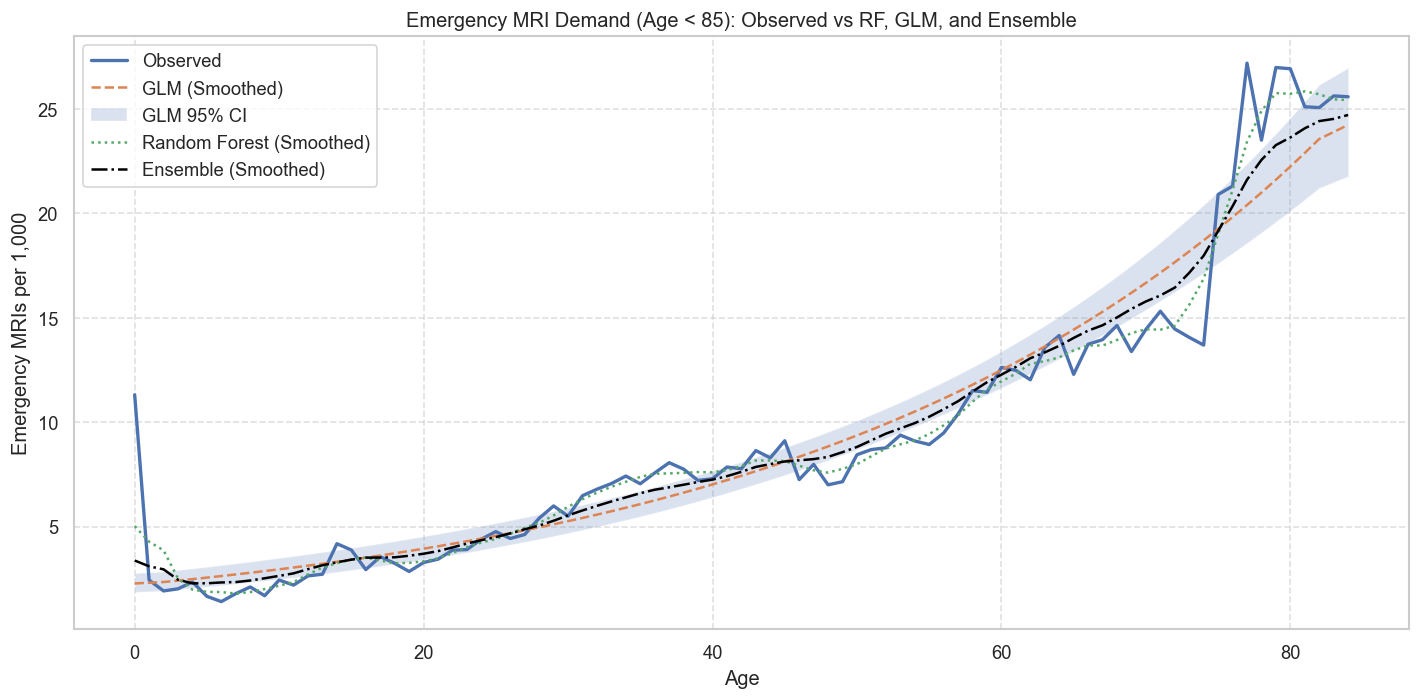

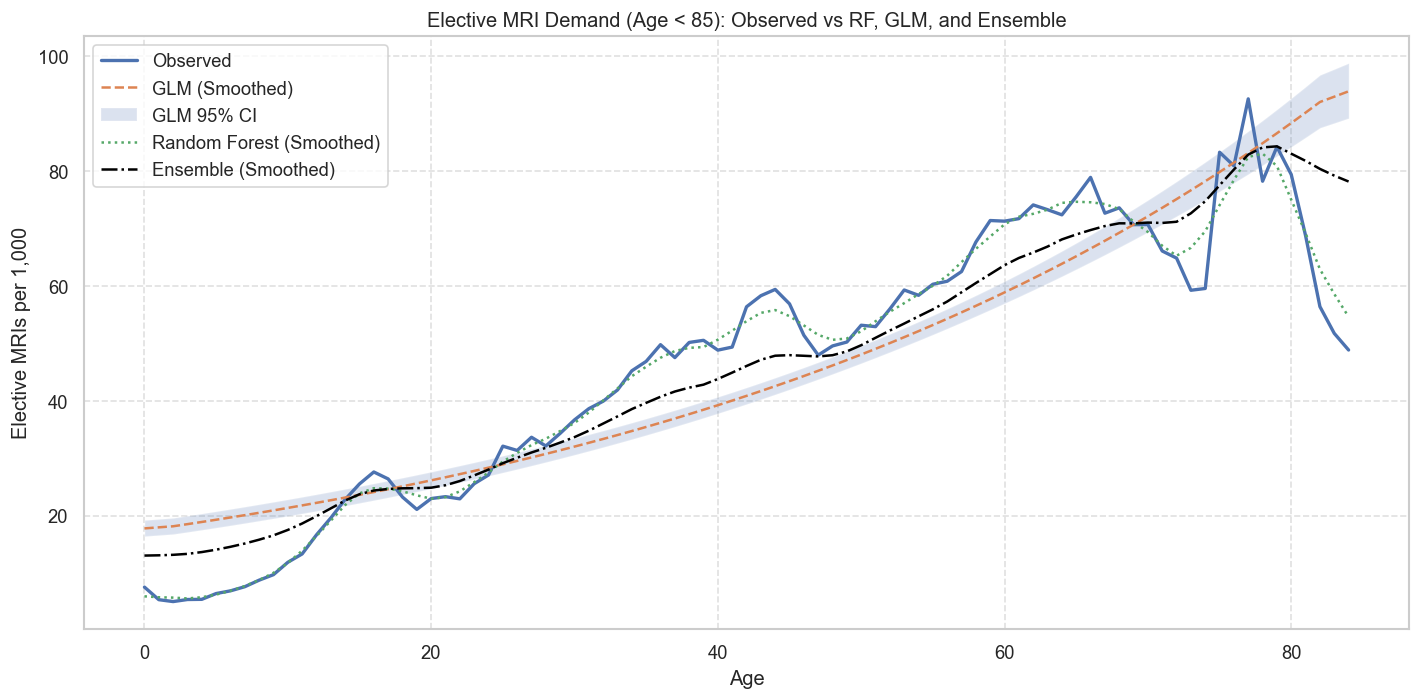

In [22]:
# ------------------------------------------------------------
# Step 10.5: Visualise RF & Ensemble Predictions for MRI Age < 85
# ------------------------------------------------------------

# ----------------------
# Emergency MRI Plot (<85)
# ----------------------
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_em_lt85, x="age", y="mri_emergency_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_glm_smoothed", label="GLM (Smoothed)", linestyle="--")
plt.fill_between(
    model_df_em_lt85["age"],
    model_df_em_lt85["glm_ci_lower_smoothed"],
    model_df_em_lt85["glm_ci_upper_smoothed"],
    alpha=0.2,
    label="GLM 95% CI"
)
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df_em_lt85, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.title("Emergency MRI Demand (Age < 85): Observed vs RF, GLM, and Ensemble")
plt.ylabel("Emergency MRIs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------
# Elective MRI Plot (<85)
# ----------------------
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_el_lt85, x="age", y="mri_elective_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_glm_smoothed", label="GLM (Smoothed)", linestyle="--")
plt.fill_between(
    model_df_el_lt85["age"],
    model_df_el_lt85["glm_ci_lower_smoothed"],
    model_df_el_lt85["glm_ci_upper_smoothed"],
    alpha=0.2,
    label="GLM 95% CI"
)
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df_el_lt85, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")

plt.title("Elective MRI Demand (Age < 85): Observed vs RF, GLM, and Ensemble")
plt.ylabel("Elective MRIs per 1,000")
plt.xlabel("Age")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# ------------------------------------------------------------
# Step 10.6: Evaluate Smoothed Predictions for MRI (Age < 85)
# ------------------------------------------------------------

print("----- Emergency MRI Demand (Age < 85) -----")
evaluate(
    model_df_em_lt85["mri_emergency_per_1k"],
    model_df_em_lt85["predicted_glm_smoothed"],
    "MRI Emergency GLM (Smoothed)"
)
evaluate(
    model_df_em_lt85["mri_emergency_per_1k"],
    model_df_em_lt85["predicted_rf_smoothed"],
    "MRI Emergency RF (Smoothed)"
)
evaluate(
    model_df_em_lt85["mri_emergency_per_1k"],
    model_df_em_lt85["predicted_ensemble_smoothed"],
    "MRI Emergency Ensemble (Smoothed)"
)

print("\n----- Elective MRI Demand (Age < 85) -----")
evaluate(
    model_df_el_lt85["mri_elective_per_1k"],
    model_df_el_lt85["predicted_glm_smoothed"],
    "MRI Elective GLM (Smoothed)"
)
evaluate(
    model_df_el_lt85["mri_elective_per_1k"],
    model_df_el_lt85["predicted_rf_smoothed"],
    "MRI Elective RF (Smoothed)"
)
evaluate(
    model_df_el_lt85["mri_elective_per_1k"],
    model_df_el_lt85["predicted_ensemble_smoothed"],
    "MRI Elective Ensemble (Smoothed)"
)


----- Emergency MRI Demand (Age < 85) -----
MRI Emergency GLM (Smoothed)   | MAE: 1.31 | RMSE: 1.97 | R²: 0.917
MRI Emergency RF (Smoothed)    | MAE: 0.60 | RMSE: 1.07 | R²: 0.976
MRI Emergency Ensemble (Smoothed) | MAE: 0.94 | RMSE: 1.52 | R²: 0.951

----- Elective MRI Demand (Age < 85) -----
MRI Elective GLM (Smoothed)    | MAE: 9.15 | RMSE: 11.98 | R²: 0.740
MRI Elective RF (Smoothed)     | MAE: 1.81 | RMSE: 2.85 | R²: 0.985
MRI Elective Ensemble (Smoothed) | MAE: 5.88 | RMSE: 7.86 | R²: 0.888


In [36]:
def compute_mri_emergency_per_1k(modality_counts_df, population_dict):
    """
    Compute Emergency MRI demand per 1,000 people by ONS age bands.
    """
    df = modality_counts_df[["age_band", "MRI_Emergency"]].copy()
    df["population_2024"] = df["age_band"].map(population_dict)

    # Ensure population is numeric
    df["population_2024"] = pd.to_numeric(df["population_2024"], errors="coerce")
    df.dropna(inplace=True)

    # Rate per 1,000
    df["mri_emergency_per_1k"] = (df["MRI_Emergency"] / df["population_2024"]) * 1000

    # Raw demand and PDF
    df["demand_emergency"] = (df["mri_emergency_per_1k"] * df["population_2024"]) / 1000
    total_demand = df["demand_emergency"].sum()
    df["pdf_emergency"] = df["demand_emergency"] / total_demand

    return df


In [37]:
def compute_mri_elective_per_1k(modality_counts_df, population_dict):
    """
    Compute Elective MRI demand per 1,000 people by ONS age bands.
    """
    df = modality_counts_df[["age_band", "MRI_Elective"]].copy()
    df["population_2024"] = df["age_band"].map(population_dict)

    # Ensure population is numeric
    df["population_2024"] = pd.to_numeric(df["population_2024"], errors="coerce")
    df.dropna(inplace=True)

    # Rate per 1,000
    df["mri_elective_per_1k"] = (df["MRI_Elective"] / df["population_2024"]) * 1000

    # Raw demand and PDF
    df["demand_elective"] = (df["mri_elective_per_1k"] * df["population_2024"]) / 1000
    total_demand = df["demand_elective"].sum()
    df["pdf_elective"] = df["demand_elective"] / total_demand

    return df


In [27]:
# Convert age_band_population to a dict
population_dict = dict(zip(age_band_population["age_band"], age_band_population["population_2024"]))

# Then call your MRI function
mri_emergency_df = compute_mri_emergency_per_1k(mri_naive_df, population_dict)
mri_elective_df = compute_mri_elective_per_1k(mri_naive_df, population_dict)

# Check results
print(mri_emergency_df.head())
print(mri_elective_df.head())


  age_band  MRI_Emergency  population_2024  mri_emergency_per_1k  \
0      0-4            602           280713              2.144539   
1      5-9            612           318116              1.923827   
2    10-14           1001           326787              3.063157   
3    15-19           1038           320572              3.237962   
4    20-24           1368           339467              4.029847   

   demand_emergency  pdf_emergency  
0             602.0       0.011170  
1             612.0       0.011356  
2            1001.0       0.018574  
3            1038.0       0.019260  
4            1368.0       0.025384  
  age_band  MRI_Elective  population_2024  mri_elective_per_1k  \
0      0-4          1604           280713             5.714021   
1      5-9          2905           318116             9.131889   
2    10-14          6268           326787            19.180690   
3    15-19          7914           320572            24.687122   
4    20-24          8786           3394

In [39]:
def fit_mri_rf_emergency_under85(df, age_col="age", demand_col="mri_emergency_per_1k", window=5):
    """
    Fit Random Forest model to emergency MRI demand per 1,000 for ages <85,
    with optional rolling smoothing.

    Returns:
    - df_result: DataFrame with observed, predicted_rf, predicted_rf_smoothed
    - rf_model: Trained Random Forest model
    """
    df_sub = df[df[age_col] < 85].copy()

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_sub[[age_col]], df_sub[demand_col])
    df_sub["predicted_rf"] = rf_model.predict(df_sub[[age_col]])

    # Smooth predictions
    df_sub["predicted_rf_smoothed"] = (
        df_sub["predicted_rf"]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

    return df_sub, rf_model


def fit_mri_rf_elective_under85(df, age_col="age", demand_col="mri_elective_per_1k", window=5):
    """
    Fit Random Forest model to elective MRI demand per 1,000 for ages <85,
    with optional rolling smoothing.

    Returns:
    - df_result: DataFrame with observed, predicted_rf, predicted_rf_smoothed
    - rf_model: Trained Random Forest model
    """
    df_sub = df[df[age_col] < 85].copy()

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_sub[[age_col]], df_sub[demand_col])
    df_sub["predicted_rf"] = rf_model.predict(df_sub[[age_col]])

    # Smooth predictions
    df_sub["predicted_rf_smoothed"] = (
        df_sub["predicted_rf"]
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )

    return df_sub, rf_model


In [43]:
# Fix age dtype for filtering
merged_mri_df['age'] = pd.to_numeric(merged_mri_df['age'], errors='coerce')
merged_mri_df = merged_mri_df.dropna(subset=['age'])
merged_mri_df['age'] = merged_mri_df['age'].astype(int)

# Now safe to filter age < 85
model_df_em_lt85 = merged_mri_df[merged_mri_df["age"] < 85].copy()
model_df_em_lt85.dropna(subset=["mri_emergency_per_1k"], inplace=True)

# Continue with RF model fitting...


In [44]:
# Emergency MRI RF model for Age < 85
model_df_em_lt85 = merged_mri_df[merged_mri_df["age"] < 85].copy()
model_df_em_lt85.dropna(subset=["mri_emergency_per_1k"], inplace=True)

rf_em_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em_model.fit(model_df_em_lt85[["age"]], model_df_em_lt85["mri_emergency_per_1k"])
model_df_em_lt85["predicted_rf"] = rf_em_model.predict(model_df_em_lt85[["age"]])

# Smooth RF predictions with 5-year rolling average
model_df_em_lt85["predicted_rf_smoothed"] = (
    model_df_em_lt85["predicted_rf"]
    .rolling(window=5, center=True, min_periods=1)
    .mean()
)

# Elective MRI RF model for Age < 85
model_df_el_lt85 = merged_mri_df[merged_mri_df["age"] < 85].copy()
model_df_el_lt85.dropna(subset=["mri_elective_per_1k"], inplace=True)

rf_el_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el_model.fit(model_df_el_lt85[["age"]], model_df_el_lt85["mri_elective_per_1k"])
model_df_el_lt85["predicted_rf"] = rf_el_model.predict(model_df_el_lt85[["age"]])

# Smooth RF predictions with 5-year rolling average
model_df_el_lt85["predicted_rf_smoothed"] = (
    model_df_el_lt85["predicted_rf"]
    .rolling(window=5, center=True, min_periods=1)
    .mean()
)

# Preview predictions
print(model_df_em_lt85[["age", "mri_emergency_per_1k", "predicted_rf_smoothed"]].head())
print(model_df_el_lt85[["age", "mri_elective_per_1k", "predicted_rf_smoothed"]].head())


   age  mri_emergency_per_1k  predicted_rf_smoothed
0    2              2.144539               2.453067
1    7              1.923827               2.646917
2   12              3.063157               2.931183
3   17              3.237962               3.486860
4   22              4.029847               4.355502
   age  mri_elective_per_1k  predicted_rf_smoothed
0    2             5.714021              12.462880
1    7             9.131889              15.029082
2   12            19.180690              17.366748
3   17            24.687122              22.007240
4   22            25.881750              28.091720
